In [ ]:
!pip install git+https://github.com/omarcastano/MasterThesis.git
!git clone https://github.com/omarcastano/MLutilities.git

In [ ]:
!nvidia-smi

Tue Oct  4 22:54:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load libraries
from typing import List, Callable, Union, Tuple
import multiprocessing as mp
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import os
import matplotlib.patches as mpatches
import numpy as np
import torch
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

#custom libary
import MasterThesis.preprocessing as DP
from MasterThesis import EDA
#from MasterThesis.utils import metrics, simclr, data_for_seg
#from MasterThesis.utils import data_for_seg

#import wandB
import wandb
wandb.login(key="ed6b4f7a25cd803c9ce7a66dbfba2353fe5bb5d2")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
drive_path = '/content/drive/MyDrive' 
drive_path = '/mnt/h/Mi unidad'
drive_path="/content"

In [ ]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)

#mask = np.isin(y_train.copy(), [0, 1, 2]).ravel()
#X_train = X_train[mask, :, :, :]
#y_train = y_train[mask, :]

select_classes = {0:"airplane",   
                1:"automobile", 
                2:"bird",       
                3:"cat",        
                4:"deer",      
                5:"dog",        
                6:"frog",       
                7:"horse",      
                8:"ship",       
                9:"truck"}     

path_to_save_images = "/content/Images"
#path_to_save_images = "/content/drive/MyDrive/Maestria/Theses/CIFAR/Images"

import os

if not os.path.isdir("/content/Images"):
    os.mkdir("/content/Images")

for folder in select_classes.values():
    os.mkdir(path_to_save_images + "/" + f"{folder}")

images = []
labels = []
classes = []
for i in tqdm(range(len(X_train))):
    np.savez(f"{path_to_save_images}/{select_classes[y_train[i][0]]}/{i}.npz", X_train[i].transpose(2,0,1))

    images.append(f"{select_classes[y_train[i][0]]}/{i}.npz")
    labels.append(y_train[i][0])
    classes.append(select_classes[y_train[i][0]])


metadata = pd.DataFrame({"Image":images, "Labels":labels, "Classes":classes})
metadata.to_csv("/content/metadata.csv", index=False)
#metadata.to_csv("/content/drive/MyDrive/Maestria/Theses/CIFAR/metadata.csv", index=False)
metadata.head()

170508288/170498071 [==============================] - 3s 0us/step


  0%|          | 0/60000 [00:00<?, ?it/s]

,Image,Labels,Classes
0,frog/0.npz,6,frog
1,truck/1.npz,9,truck
2,truck/2.npz,9,truck
3,deer/3.npz,4,deer
4,automobile/4.npz,1,automobile


In [ ]:
#Load metadata
path_to_metadata =  f'{drive_path}/metadata.csv'
#path_to_metadata =  f'{drive_path}/Maestria/Theses/CIFAR/metadata.csv'
metadata = pd.read_csv(path_to_metadata).sample(frac=1, random_state=42)
print(metadata.shape)
metadata.head()

(60000, 3)


,Image,Labels,Classes
12628,automobile/12628.npz,1,automobile
37730,truck/37730.npz,9,truck
39991,bird/39991.npz,2,bird
8525,ship/8525.npz,8,ship
8279,deer/8279.npz,4,deer


In [ ]:
# path to image and masks
path_to_images = f"{drive_path}/Maestria/Theses/CIFAR/Images/"
path_to_images = f"{drive_path}/Images/"
select_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#select_classes = ["airplane", "automobile", "bird"]

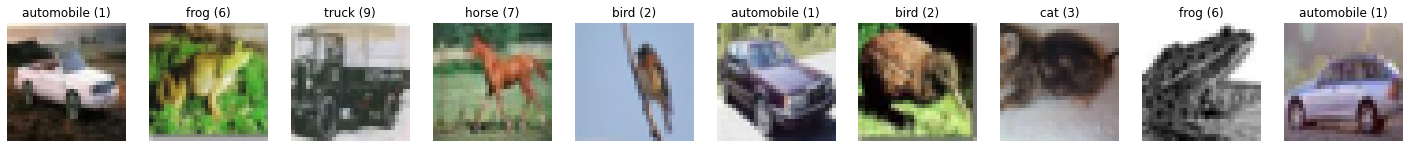

In [ ]:
#Plot images
fig = EDA.visualize_images_and_labels(path_to_images, metadata.sample(frac=1), temporal_dim=False, n=10, figsize=(25,7), scale_factor=255 )

## Create Datasets

In [ ]:
import torch
from MasterThesis.utils.classification.simclr import CustomDataset, visualize_augmented_images

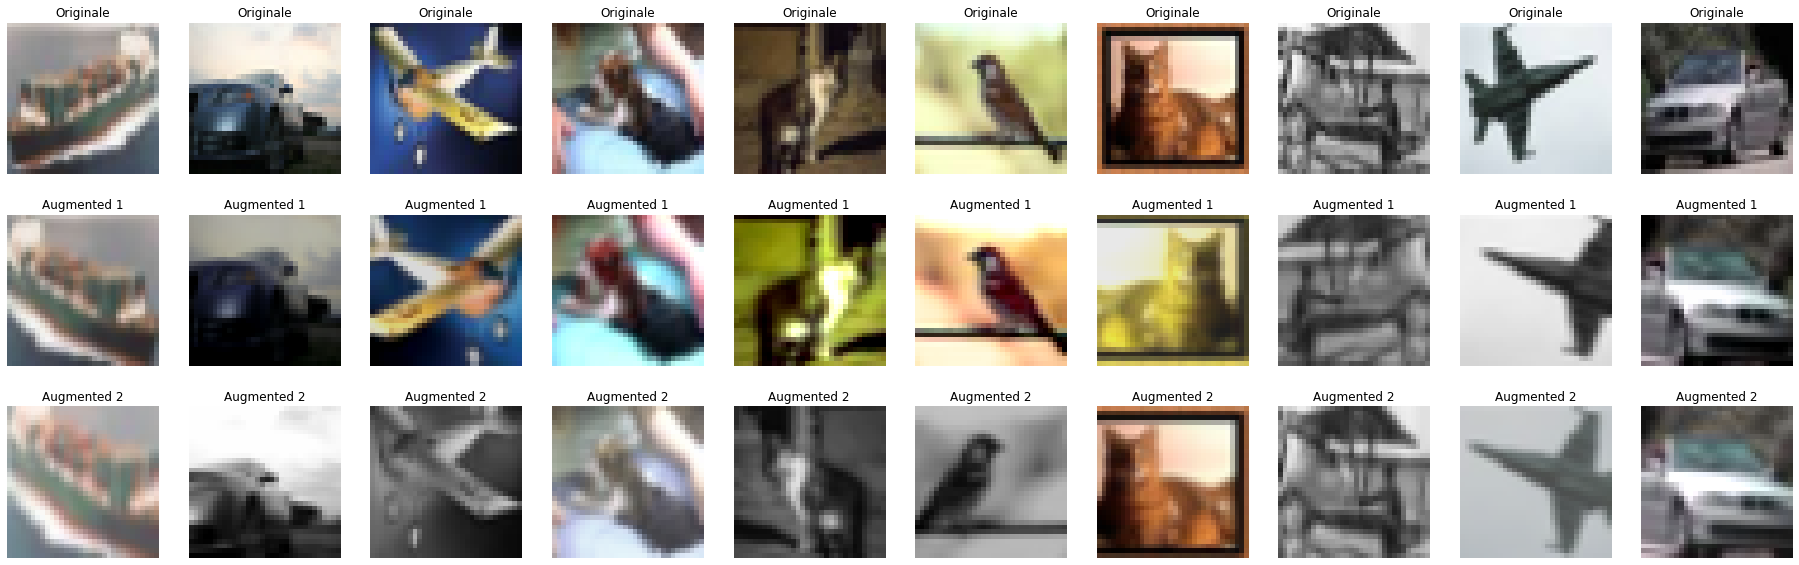

In [ ]:
ds = CustomDataset(path_to_images, metadata.sample(10), return_original=True, normalizing_factor=255)
visualize_augmented_images(ds)

# Self-Supervised model

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [ ]:
import torch
from torch.nn import Module
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from MasterThesis.models.classification.simclr import SimCLR
from MasterThesis.utils.classification.losses import NTXentLoss
from pl_bolts.optimizers import LARS
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR


In [ ]:
n = metadata.shape[0]
metadata_train = metadata.iloc[0:int(n*0.98)]
metadata_test = metadata.iloc[int(n*0.98):] 
print(metadata_train.shape)
print(metadata_test.shape)

(58800, 3)
(1200, 3)


In [ ]:
drive_path = '/content/drive/MyDrive' 
path_to_save_model = f"{drive_path}/Maestria/Theses/CIFAR/models/CIFAR10"

In [ ]:
metadata_kwargs = {
    "path_to_images": path_to_images,
    "path_to_save_model": path_to_save_model,  # path_to_save_model,  # Path to save the model that is being trained (do not include the extension .pt or .pth)
    "path_to_load_model": None,  # Path to load a model from a checkpoint (useful to handle notebook disconnection)
    "metadata": metadata,
    "metadata_train": metadata_train,
    "metadata_test": metadata_test,
    "device": device,
}

hypm = {
    "version": "SSL-SimCLR",
    "pretrained": "SSL-SimCLR",  # SSL methodology. If not None path_to_load_backbone must be provided
    "amount_ss_data": metadata_train.shape[0],
    "input_shape": [32, 32],
    "backbone": "resnet18",
    "cifar":True,
    "temperature": 0.5,  # Temperature hyperparameter used in the NTXenLoss function
    "weight_decay": 0.000001,
    "learning_rate": 0.3,
    "batch_size": 512,
    "normalizing_factor":255,
    "epochs": 300,
}

wandb_kwargs = {
    "project": "CIFAR10",
    "entity": "omar_castano",
    "config": hypm,
    "id": "20d9u49l",
    "name": "SSL-SimCLR",
    "resume": True,
}

In [ ]:
from MasterThesis.utils.classification.simclr import run_train

In [ ]:
run_train(wandb, wandb_kwargs, metadata_kwargs)